In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold

# Load the original dataset
original_df = pd.read_csv("training_set_VU_DM.csv")
original_test_set = pd.read_csv("test_set_VU_DM.csv")
df = original_df.copy()
df_test = original_test_set.copy()

In [30]:
# Drop columns with more than 70% missing values
missing_threshold = 0.7 
missing_fractions = df.isnull().mean()
columns_to_drop = missing_fractions[missing_fractions > missing_threshold].index.tolist()
columns_to_drop.append('position')
df.drop(columns=columns_to_drop, axis=1, inplace=True, errors='ignore')
df_test.drop(columns=columns_to_drop, axis=1, inplace=True, errors='ignore')
print(f"Dropped columns due to missing values > {missing_threshold*100}%: {columns_to_drop}")

print("Missing values before cleaning:")
print(df.isnull().sum()[df.isnull().sum() > 0])
print("Missing values before cleaning: test")
print(df_test.isnull().sum()[df_test.isnull().sum() > 0])

Dropped columns due to missing values > 70.0%: ['visitor_hist_starrating', 'visitor_hist_adr_usd', 'srch_query_affinity_score', 'comp1_rate', 'comp1_inv', 'comp1_rate_percent_diff', 'comp2_rate_percent_diff', 'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv', 'comp4_rate_percent_diff', 'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv', 'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv', 'comp7_rate_percent_diff', 'comp8_rate_percent_diff', 'gross_bookings_usd', 'position']
Missing values before cleaning:
prop_review_score               7364
prop_location_score2         1090348
orig_destination_distance    1607782
comp2_rate                   2933675
comp2_inv                    2828078
comp3_rate                   3424059
comp3_inv                    3307357
comp5_rate                   2735974
comp5_inv                    2598327
comp8_rate                   3041693
comp8_inv                    2970844
dtype: int64
Missing values before cleaning: test
prop_review_score        

In [31]:
# Handling missing values of remaining variables
if "prop_review_score" in df.columns:
    df["prop_review_score"] = df["prop_review_score"].fillna(df["prop_review_score"].median())
    df_test["prop_review_score"] = df_test["prop_review_score"].fillna(df_test["prop_review_score"].median())

if "prop_location_score2" in df.columns:
    df["prop_location_score2"] = df["prop_location_score2"].fillna(0)
    df_test["prop_location_score2"] = df_test["prop_location_score2"].fillna(0)

if "orig_destination_distance" in df.columns:
    df["orig_destination_distance"] = df["orig_destination_distance"].fillna(df["orig_destination_distance"].median())
    df_test["orig_destination_distance"] = df_test["orig_destination_distance"].fillna(df_test["orig_destination_distance"].median())

# Handling competitor information
for i in range(1, 9):
    rate_col = f"comp{i}_rate"
    inv_col = f"comp{i}_inv"
    diff_col = f"comp{i}_rate_percent_diff"

    for col in [rate_col, inv_col, diff_col]:
        if col in df.columns:
            fill_val = 0 if "percent_diff" not in col else 0.0
            df[col] = df[col].fillna(fill_val)
            df_test[col] = df_test[col].fillna(fill_val)

# Save to a new file
df.to_csv("training_set_cleaned.csv", index=False)
df_test.to_csv("test_set_cleaned.csv", index=False)


print("Missing values after cleaning:")
print(df.isnull().sum()[df.isnull().sum() > 0])

print("Missing values after cleaning: test")
print(df_test.isnull().sum()[df_test.isnull().sum() > 0])

Missing values after cleaning:
Series([], dtype: int64)
Missing values after cleaning: test
Series([], dtype: int64)


In [3]:
# Load your cleaned dataset
df = pd.read_csv("training_set_cleaned.csv")

# Step 1: Create a relevance score
df["relevance"] = df["booking_bool"] * 5 + ((df["click_bool"] == 1) & (df["booking_bool"] == 0)) * 1

# Step 2: Aggregate to one label per search
relevance_by_search = df.groupby("srch_id")["relevance"].max().reset_index()

# Step 3: Apply StratifiedKFold based on srch_id and its highest relevance
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Example: split for one fold (train/test)
for train_idx, test_idx in skf.split(relevance_by_search["srch_id"], relevance_by_search["relevance"]):
    train_search_ids = relevance_by_search.loc[train_idx, "srch_id"]
    test_search_ids = relevance_by_search.loc[test_idx, "srch_id"]
    break  # Only use the first split

# Step 4: Filter original DataFrame based on srch_id
train_df = df[df["srch_id"].isin(train_search_ids)].reset_index(drop=True)
test_df = df[df["srch_id"].isin(test_search_ids)].reset_index(drop=True)

# Optional: Save to file
train_df.to_csv("train_split.csv", index=False)
test_df.to_csv("test_split.csv", index=False)

KeyboardInterrupt: 

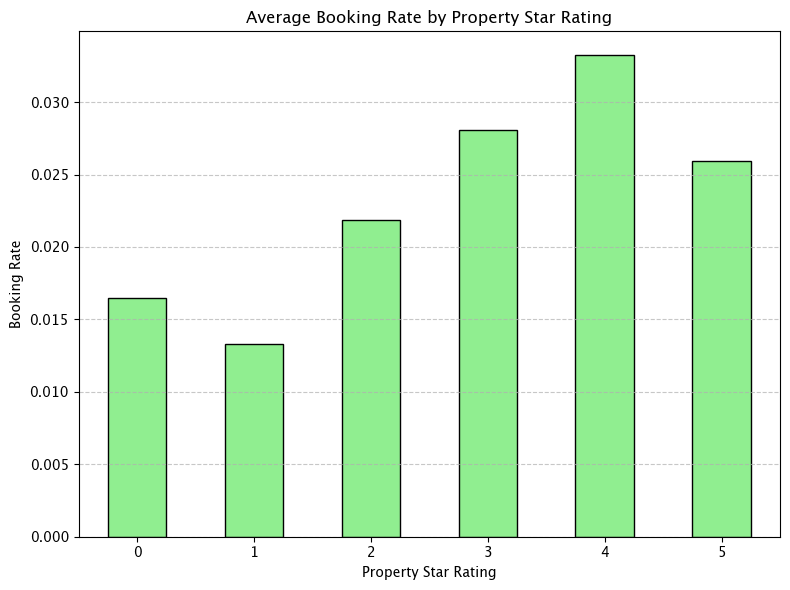

In [10]:
# Load the original full dataset (uncleaned)
df = pd.read_csv("training_set_VU_DM.csv")

# Ensure relevant columns exist and handle missing star ratings
df = df[["prop_starrating", "booking_bool"]].dropna()

# Group by star rating and compute booking rate
booking_rate_by_star = df.groupby("prop_starrating")["booking_bool"].mean().sort_index()

# Plotting
plt.figure(figsize=(8, 6))
booking_rate_by_star.plot(kind='bar', color='lightgreen', edgecolor='black')
plt.title("Average Booking Rate by Property Star Rating")
plt.xlabel("Property Star Rating")
plt.ylabel("Booking Rate")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

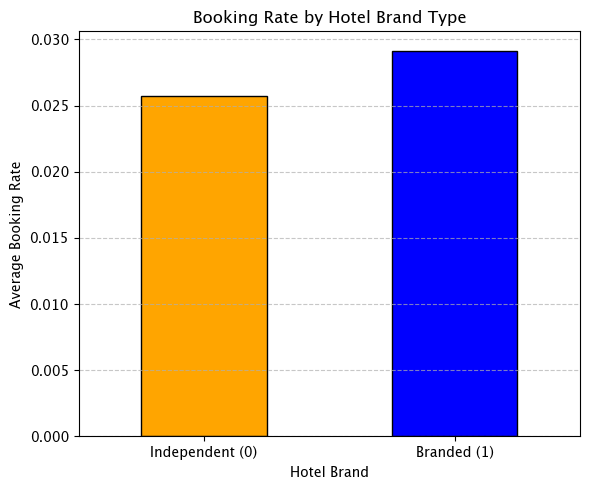

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv("training_set_VU_DM.csv", usecols=["prop_brand_bool", "booking_bool"])

# Drop rows with missing brand information
df = df[df["prop_brand_bool"].notna()]

# Compute average booking rate by brand flag
booking_rate_by_brand = df.groupby("prop_brand_bool")["booking_bool"].mean()

# Rename index for readability
booking_rate_by_brand.index = ["Independent (0)", "Branded (1)"]

# Plot
plt.figure(figsize=(6, 5))
booking_rate_by_brand.plot(kind='bar', color=['orange', 'blue'], edgecolor='black')

plt.title("Booking Rate by Hotel Brand Type")
plt.xlabel("Hotel Brand")
plt.ylabel("Average Booking Rate")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
